### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 6
### Due: Saturday, Mar 14th at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [224]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

## Part 1

In [28]:
#import things
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
from scipy.stats import laplace
import corner
import numdifftools as nd
from scipy.stats import uniform
from scipy import stats
import numpy as np
import emcee
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

Text(0.5, 1.0, 'Feature Scatter Plot')

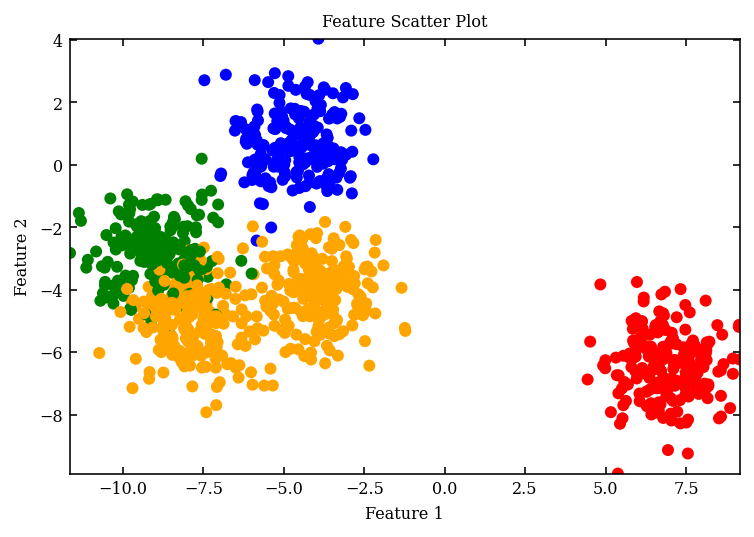

In [156]:
#1 same as HW3
#read in the data
data=np.load('../../../homeworks/hw_data/hw6_data_1.npy')
#slice array
feat1=data[:,0]
feat2=data[:,1]
label=data[:,2]
#print(label)

#plotting scatterplot
#there is almost certainly a better way to do this but this works
colormap = np.array(['red', 'green', 'blue','orange']) #set colors
for i in range(len(feat1)): #look to see label and set color
    x=0
    if label[i]==0:
        x=0
    elif label[i]==1:
        x=1
    elif label[i]==2:
        x=2
    else:
        x=3
    fig = plt.scatter(feat1[i],feat2[i],c=colormap[x],ec='none') #plot
#add some labels
plt.axis
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Feature Scatter Plot")

## Part 2

In [90]:
#taking code from lecture 14
x = np.concatenate([feat1,feat2]) #changing form of data to work

bwrange = np.linspace(.1, 1, 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=5) # Try each bandwidth with K-folds
grid.fit(x[:, None]) #Fit our Data
h_opt = grid.best_params_['bandwidth'] #get optimum value
print("The Optimal Bandwidth is:",h_opt)

The Optimal Bandwidth is: 0.4413793103448276


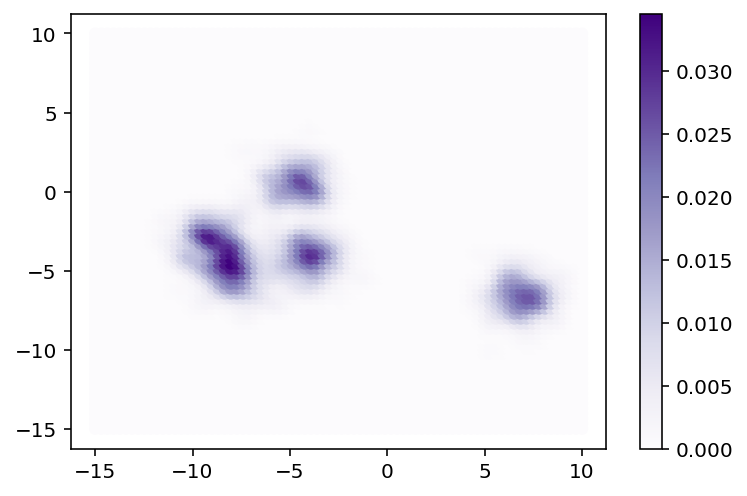

In [102]:
from sklearn.neighbors import KernelDensity
#transmform data
X = np.vstack((feat1, feat2)).T
# Two 2-D normal distributions
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(X) #fit the model to the data

#create a grid
u = v = np.linspace(-15,10,80)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

#plot
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()

## Part 3

We need to have k= 100


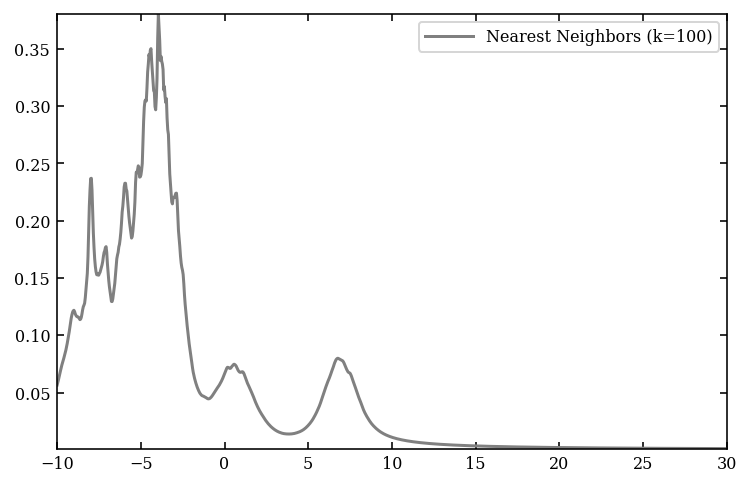

In [242]:
from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist
from sklearn.neighbors import KernelDensity

# Compute density with Bayesian nearest neighbors
xN = np.concatenate([feat1,feat2]) 
N = 1000 #number of points
k = 100 #Number of neighbors
t = np.linspace(-10, 30, 1000)

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(xN[:, None])
dens_nbrs = nbrs.eval(t[:, None]) / N

plt.plot(t, dens_nbrs, '-', lw=1.5, color='gray', 
         zorder=2, label="Nearest Neighbors (k=%i)" % k)
plt.legend()
print("We need to have k=",k)

This is good but we want a 2d plot.

We need to have k= 100


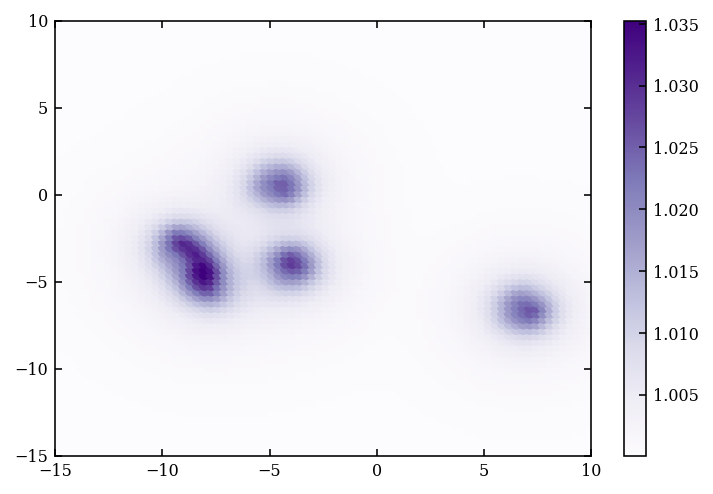

In [150]:
from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist
from sklearn.neighbors import KernelDensity
# Compute density with Bayesian nearest neighbors
xN = np.concatenate([feat1,feat2]) 
N = 1000 #number of points
k = 100 #Number of neighbors
t = np.linspace(-10, 30, 1000)

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(X)
#dens_nbrs = nbrs.eval(xN) / N

u = v = np.linspace(-15,10,80) #grid
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(nbrs.eval(Xgrid)/N) #evaluate the model on the grid

#plot
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()
print("We need to have k=",k)

### Part 4

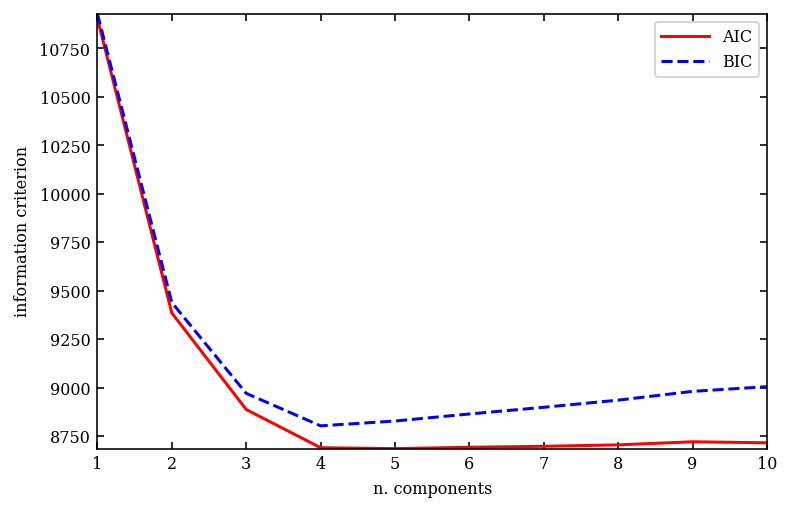

The optimum number of components is 4 acording to BIC


In [126]:
#taking some more code from lecture 14
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

#set up data

X = np.vstack((feat1, feat2)).T

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

#make the plot
plt.plot(N, AIC, '-', label='AIC',color='r')
plt.plot(N, BIC, '--', label='BIC',color='b')
plt.xlabel('n. components')
plt.ylabel('information criterion')
plt.legend()
plt.show()

#print our findings
print("The optimum number of components is 4 acording to BIC")

(array([[0.00720828, 0.02450816, 0.06343288, 0.10091594, 0.10812422,
         0.14993226, 0.08505772, 0.04180803, 0.07208282, 0.09803263,
         0.14993226, 0.15858219, 0.06199122, 0.02594981, 0.00288331,
         0.00288331, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00864994, 0.02018319,
         0.05478294, 0.08073275, 0.06775785, 0.03604141, 0.02018319],
        [0.        , 0.        , 0.00144166, 0.00288331, 0.00576663,
         0.03459975, 0.08073275, 0.11100754, 0.13263238, 0.15569888,
         0.16579048, 0.16867379, 0.15137391, 0.09082435, 0.04036638,
         0.03748306, 0.05766625, 0.07784944, 0.06343288, 0.0331581 ,
         0.02739147, 0.00144166, 0.00144166, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]]),
 array([-11.64348431, -10.94983771, -10.25619111,  -9.56254451,
         -8.86889791,  -8.17525132,  -7.48160472,  -6.78795812,
         -6.09431152,  -5.40066492,  -4.

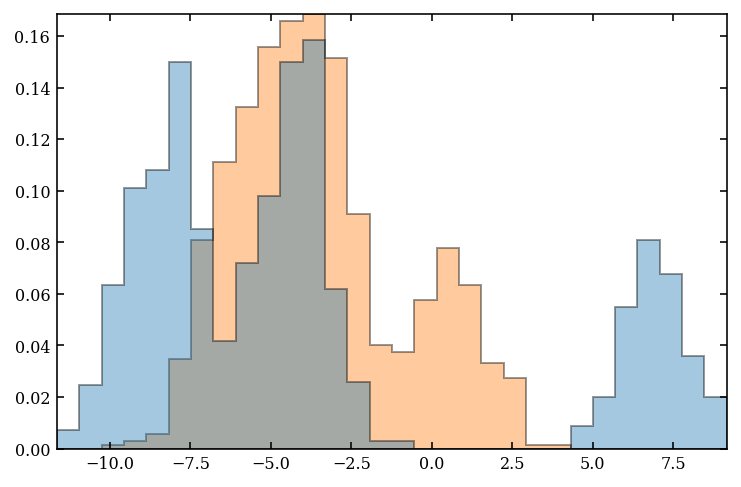

In [241]:
#fit the data
gmm = mixture.GaussianMixture(n_components=4, covariance_type="full").fit(X)
#print(gmm.means_,gmm.covariances_)

#code from lecture 14
x = np.linspace(-15, 10, 1000)
logprob = M_best.score_samples(X)
responsibilities = M_best.predict_proba(X)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)




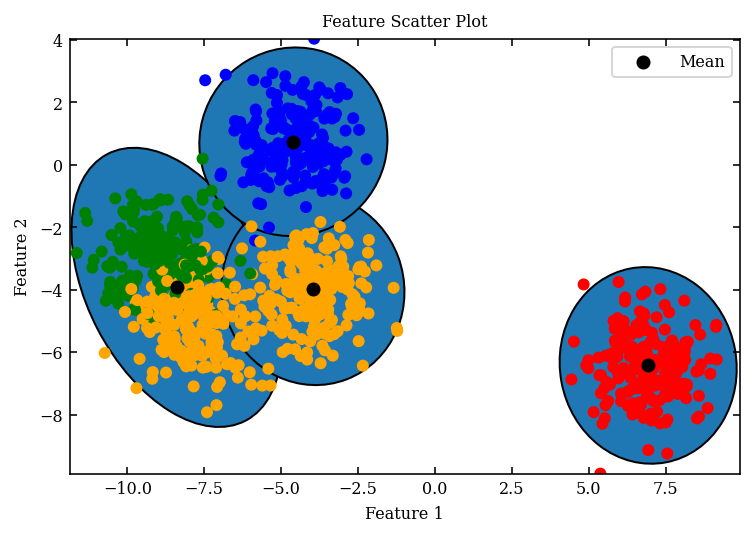

In [240]:
#create the 2d plot with the ellipse and means plot
colormap = np.array(['red', 'green', 'blue','orange'])
fig, ax = plt.subplots()

#draw the ellipse with our fit
draw_ellipse(gmm.means_[0],gmm.covariances_[0])
draw_ellipse(gmm.means_[1],gmm.covariances_[1])
draw_ellipse(gmm.means_[2],gmm.covariances_[2])
draw_ellipse(gmm.means_[3],gmm.covariances_[3])

#put in original data
for i in range(len(feat1)):
    x=0
    if label[i]==0:
        x=0
    elif label[i]==1:
        x=1
    elif label[i]==2:
        x=2
    else:
        x=3
    fig = ax.scatter(feat1[i],feat2[i],c=colormap[x],ec='none')

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_title("Feature Scatter Plot")
#print(gmm.means_[0,0])

#plot the means for each one
ax.scatter(gmm.means_[0,0],gmm.means_[0,1],color='k')
ax.scatter(gmm.means_[1,0],gmm.means_[1,1],color='k')
ax.scatter(gmm.means_[2,0],gmm.means_[2,1],color='k')
ax.scatter(gmm.means_[3,0],gmm.means_[3,1],color='k',label="Mean")
ax.legend()


## Part 5

Text(0.5, 1.0, 'Original')

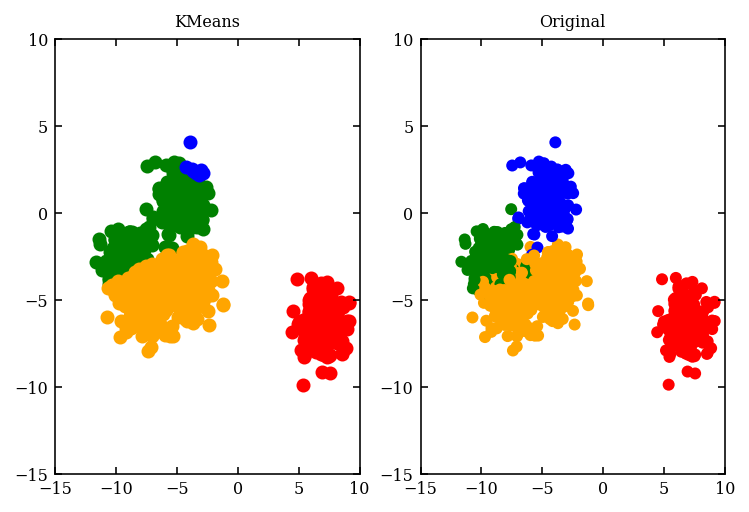

In [186]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

#standard scalar
scaler = preprocessing.StandardScaler()

#fit the kmeans
x=np.concatenate([feat1,feat2])
clf = KMeans(n_clusters=4) 
clf.fit(scaler.fit_transform(X))

#Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
#centers = clf.cluster_centers_ #location of the clusters
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
#print(cluster_centers)

#Predict the labels for the scaled data.
labels = clf.predict(X) #labels for each of the points

fig, (ax1, ax2) = plt.subplots(1, 2) #set up plot


# plot the data color-coded by cluster id
colors = ['red', 'green', 'blue','orange']
for ii in range(4):
    ax1.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii])


#orginal plot
colormap = np.array(['red', 'green', 'blue','orange'])
for i in range(len(feat1)):
    x=0
    if label[i]==0:
        x=0
    elif label[i]==1:
        x=1
    elif label[i]==2:
        x=2
    else:
        x=3
    fig = ax2.scatter(feat1[i],feat2[i],c=colormap[x],ec='none')
#make it presentable
ax1.set_xlim(-15,10)
ax2.set_xlim(-15,10)
ax1.set_ylim(-15,10)
ax2.set_ylim(-15,10)
ax1.set_title("KMeans")
ax2.set_title("Original")

<span style="color:green"> NP: Correct! Good job! </span>